<a href="https://colab.research.google.com/github/cccaballero1/EspACDD/blob/main/Procesamiento_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spotipy


import os
import re
import sys
import json
import time
#import config
import spotipy
import pandas as pd


from tqdm import tqdm
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 6.6 MB/s eta 0:00:00


In [ ]:
import os
import json

path = r'C:\Users\admin\Downloads\spotify_million_playlist_dataset'

def loop_slices(path, num_slices=2, limit=1000):
    """
    Each slice is a .json file containing 1000 playlists i.e.: 1 slice is 1000 playlists 20 slices is: 20,000 playlists.
    Parameters:
        num_slices (int): Number of slices to return, max 1000.
        path (str): Path to the Spotify Million Playlist.
        limit (int): Limit the total number of playlists to extract.

    Output:
        mpd_playlists (list): a list of dictionaries of all the playlists.
    """
    cnt = 0
    total_playlists = 0
    mpd_playlists = []
    filenames = os.listdir(path)

    for filename in sorted(filenames):
        cnt += 1
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.path.join(path, filename)
            with open(fullpath) as f:
                current_slice = json.load(f)

            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)
                total_playlists += 1

                if total_playlists >= limit:
                    return mpd_playlists

            if cnt == num_slices:
                break

    return mpd_playlists

# Example usage:
result = loop_slices(path, num_slices=2, limit=1000)
print(len(result))  # This will print the number of playlists extracted (up to 1000)


0


In [ ]:
import json
from datetime import datetime
import pandas as pd  # Make sure to import pandas

def create_csv(playlists, extended=False, limit=1000):
    """
    This function will construct a dataframe and write to .csv file for the input playlists,
    this .csv will have a single cell with all the tracks in the playlist.
    An extended parameter is available to extend the tracks in a list to be a single cell per song,
    this will return an additional .csv file.

    Parameters:
        playlists (list): a list of dictionaries such as that from the loop_slices() function.
        extended (boolean): boolean to enable the extended .csv file generation
        limit (int): Limit the number of playlists to process.

    Output:
        MPD.csv: .csv file with the playlists
        MPD.csv: .csv file with extended song columns
    """
    if limit > len(playlists):
        limit = len(playlists)

    df = pd.DataFrame(playlists[:limit])
    df.to_csv(r'C:\Users\admin\Downloads\Spotify Challenge\json\MPD.csv', index=False)

    if extended:
        df_list = []
        for playlist in playlists[:limit]:
            df_list.append(pd.DataFrame(playlist))

        df_extended = pd.concat(df_list, axis=0)

        cols_to_keep = ['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums',
                'num_followers','num_edits', 'duration_ms', 'num_artists']
        df_extended = df_extended.reset_index().pivot(values='tracks',index=cols_to_keep, columns='index')
        df_extended.reset_index(inplace=True)
        df_extended = df_extended.rename_axis(None, axis=1)
        df_extended.sort_values('pid', inplace=True)

        output_file = r'C:\Users\admin\Downloads\Spotify Challenge\json\{}_MPD_Extended.csv'.format(datetime.now().strftime("%Y_%d_%m_%H_%M_%S"))
        df_extended.to_csv(output_file, index=False)
        print(f"Extended CSV file created: {output_file}")

# Load playlists from file
playlists_path = r'C:\Users\admin\Downloads\Spotify Challenge\Data\playlists.json'
with open(playlists_path, 'r') as file:
    playlists = json.load(file)

# Call create_csv function with the list of dictionaries
create_csv(playlists, extended=True, limit=1000)


Extended CSV file created: C:\Users\admin\Downloads\Spotify Challenge\json\2024_29_03_14_33_11_MPD_Extended.csv


# Run with num_slices=1000 to run the whole data set (1M)
# It will save a .json locally

In [ ]:
import json
from datetime import datetime


def loop_slices(file_path, limit=1000):
    with open(file_path, 'r') as file:
        playlists = json.load(file)

    return playlists[:limit]


# Example usage:
path_2 = r'C:\Users\admin\Downloads\Spotify Challenge\Data\playlists.json'
playlists = loop_slices(path_2)
#print(playlists[:10])  # Print only the first 10 playlists

# Save playlists to a JSON file
json_file_path = r'C:\Users\admin\Downloads\Spotify Challenge\Data\{}_playlists_{}.json'.format(
    datetime.now().strftime("%Y_%m_%d_%H_%M_%S"), len(playlists))
with open(json_file_path, 'w') as outfile:
    json.dump(playlists, outfile, indent=2)


# Assuming create_csv takes a list of dictionaries (each representing a playlist)
def create_csv(json_file_path, extended=True):
    with open(json_file_path, 'r') as json_file:
        playlists = json.load(json_file)

    df = pd.DataFrame(playlists)
    df.to_csv(r'C:\Users\admin\Downloads\Spotify Challenge\json\MPD.csv', index=False)

    if extended:
        # Add your logic here to handle extended data for CSV creation (if applicable)
        pass


# Call the create_csv function (assuming the JSON file is valid)
create_csv(json_file_path, extended=True);


In [ ]:
import json
import csv
from datetime import datetime

def flatten_json(json_data, parent_key='', sep='_', limit=None):
    flattened_data = []
    for playlist_index, playlist in enumerate(json_data[:limit], start=1):  # Limit playlists
        for i, track in enumerate(playlist['tracks'][:limit], start=1):  # Limit tracks per playlist
            flattened_track = {}
            for key, value in track.items():
                new_key = f"{parent_key}{sep}{key}" if parent_key else key
                if isinstance(value, dict):
                    flattened_track.update(flatten_json(value, new_key, sep=sep, limit=limit))
                elif isinstance(value, list):
                    flattened_track[new_key] = ', '.join(map(str, value))
                else:
                    flattened_track[new_key] = value
            flattened_track['playlist_index'] = playlist_index  # Add playlist index as a reference
            flattened_data.append(flattened_track)
    return flattened_data

def save_as_csv(json_data, csv_file_path, limit=1000):
    if not json_data:
        print("No data to save.")
        return

    headers = set()
    all_flattened_data = []

    for playlist_index, playlist in enumerate(json_data[:limit], start=1):  # Limit playlists
        flattened_playlist = flatten_json([playlist], limit=limit)
        all_flattened_data.extend(flattened_playlist)
        headers.update(flattened_playlist[0].keys())
        if len(all_flattened_data) >= limit:
            break  # Break the loop if the limit is reached

    # Convert set to list for consistent order
    headers = list(headers)

    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Write header
        csv_writer.writeheader()

        # Write data
        for row in all_flattened_data[:limit]:  # Limit rows to 1000
            csv_writer.writerow(row)

if __name__ == "__main__":
    # Example usage:
    path_2 = r'C:\Users\admin\Downloads\Spotify Challenge\Data\playlists.json'
    playlists = loop_slices(path_2)
    print(playlists)  # Print playlists to see their content

    # Save playlists to a JSON file
    json_file_path = r'C:\Users\admin\Downloads\Spotify Challenge\Data\{}_playlists_{}.json'.format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"), len(playlists))
    with open(json_file_path, 'w') as outfile:
        json.dump(playlists, outfile, indent=2)

    # Create CSV using the saved JSON file path
    csv_file_path = r'C:\Users\admin\Downloads\Spotify Challenge\Data\{}_playlists_{}.csv'.format(datetime.now().strftime("%Y_%m_%d_%H_%M_%S"), len(playlists))
    save_as_csv(playlists, csv_file_path, limit=1000)  # Limiting to 1000 rows

    print(f"CSV file saved at: {csv_file_path}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



CSV file saved at: C:\Users\admin\Downloads\Spotify Challenge\Data\2024_03_29_14_33_38_playlists_1000.csv


In [ ]:
# # Read MPD
df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\json\MPD.csv')
df

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,False,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,False,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,False,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,False,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,False,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,old,False,995,1507852800,41,40,1,"[{'pos': 0, 'artist_name': 'Katrina', 'track_u...",8,9917901,36,NaN
996,Daze,False,996,1479254400,17,17,1,"[{'pos': 0, 'artist_name': 'PARTYNEXTDOOR', 't...",13,3699248,15,NaN
997,rap,False,997,1410307200,119,98,1,"[{'pos': 0, 'artist_name': 'LoveRance', 'track...",63,27538723,82,NaN
998,Country,False,998,1507939200,108,75,1,"[{'pos': 0, 'artist_name': 'Hunter Hayes', 'tr...",37,24950143,40,NaN


In [ ]:
import pandas as pd
import os
from datetime import datetime

# Specify the target creation date and time
target_datetime_str = '2024-03-06 12:30:00'  # Replace with your desired date and time
target_datetime = datetime.strptime(target_datetime_str, '%Y-%m-%d %H:%M:%S')

# Get all CSV files in the directory
csv_directory = r'C:\Users\admin\Downloads\Spotify Challenge\json'
csv_files = [f for f in os.listdir(csv_directory) if f.endswith('_MPD_Extended.csv')]

# Calculate the time difference for each CSV file
time_diff = lambda file: abs(target_datetime - datetime.fromtimestamp(os.path.getctime(os.path.join(csv_directory, file))))

# Find the CSV file with the closest creation date and time
closest_csv_file = min(csv_files, key=time_diff)

# Read the closest CSV file
df = pd.read_csv(os.path.join(csv_directory, closest_csv_file))
print(df)



                  name  collaborative   pid  modified_at  num_tracks  \
0           Throwbacks          False     0   1493424000          52   
1     Awesome Playlist          False     1   1506556800          39   
2              korean           False     2   1505692800          64   
3                  mat          False     3   1501027200         126   
4                  90s          False     4   1401667200          17   
...                ...            ...   ...          ...         ...   
1995               woo          False  1995   1509062400         146   
1996        NEW YEARS           False  1996   1420070400          38   
1997             JESUS          False  1997   1508371200          40   
1998               yep          False  1998   1448236800          29   
1999        Sad Music           False  1999   1464307200          16   

      num_albums  num_followers  num_edits  duration_ms  num_artists  ...  \
0             47              1          6     11532414   

In [ ]:
df.columns

Index(['name', 'collaborative', 'pid', 'modified_at', 'num_tracks',
       'num_albums', 'num_followers', 'num_edits', 'duration_ms',
       'num_artists',
       ...
       '236', '237', '238', '239', '240', '241', '242', '243', '244', '245'],
      dtype='object', length=256)

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


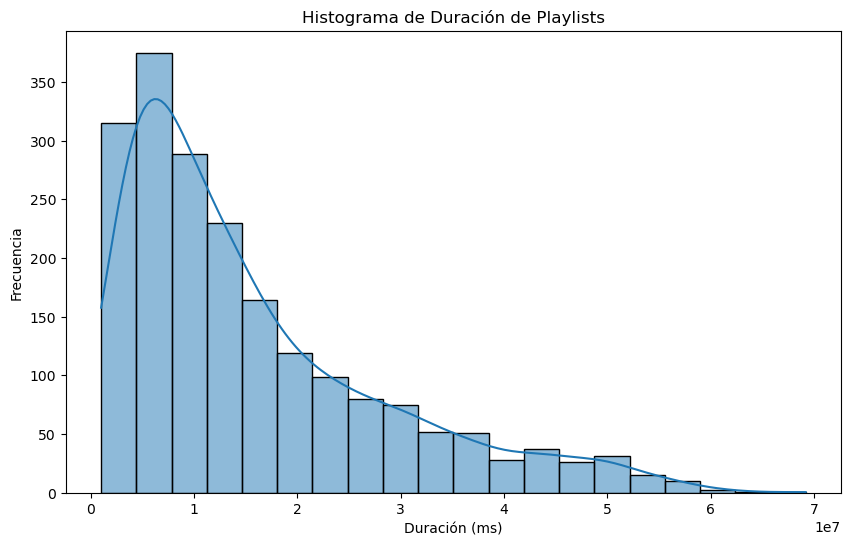

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de duración de playlists
plt.figure(figsize=(10, 6))
sns.histplot(df['duration_ms'], bins=20, kde=True)
plt.title('Histograma de Duración de Playlists')
plt.xlabel('Duración (ms)')
plt.ylabel('Frecuencia')
plt.show()

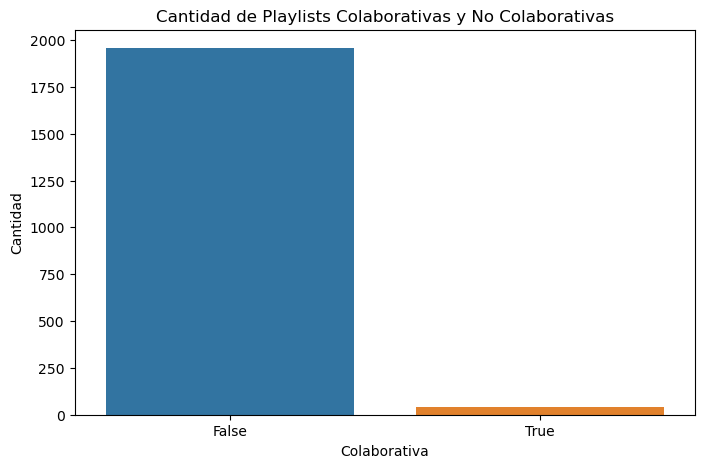

In [ ]:
# Gráfico de barras para playlists colaborativas
plt.figure(figsize=(8, 5))
sns.countplot(x='collaborative', data=df)
plt.title('Cantidad de Playlists Colaborativas y No Colaborativas')
plt.xlabel('Colaborativa')
plt.ylabel('Cantidad')
plt.show()

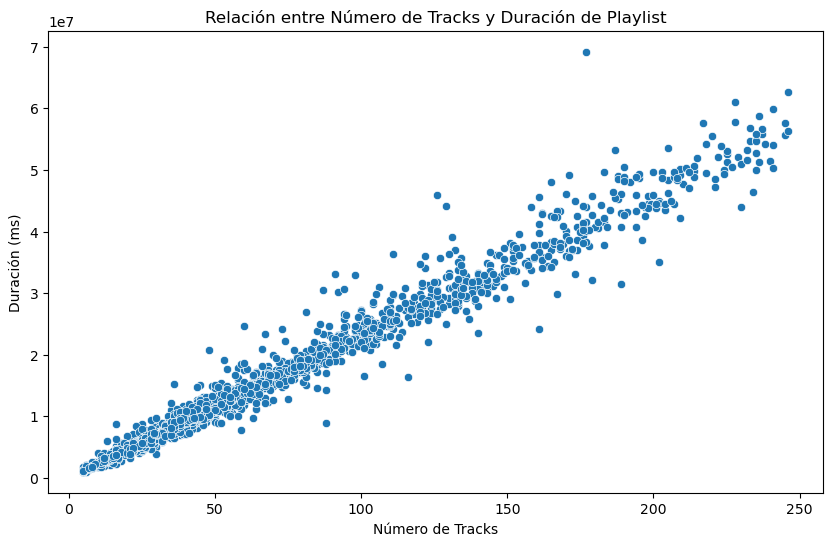

In [ ]:
# Diagrama de dispersión para num_tracks vs duration_ms
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_tracks', y='duration_ms', data=df)
plt.title('Relación entre Número de Tracks y Duración de Playlist')
plt.xlabel('Número de Tracks')
plt.ylabel('Duración (ms)')
plt.show()

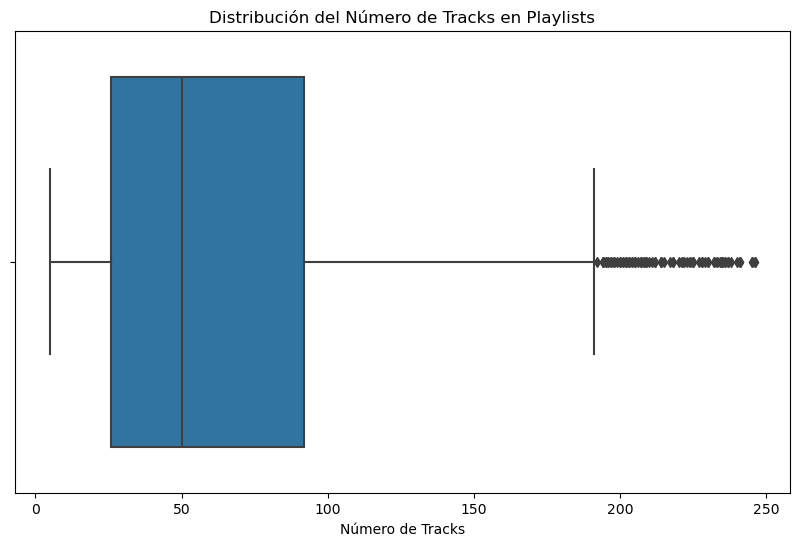

In [ ]:
# Diagrama de caja para num_tracks
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['num_tracks'])
plt.title('Distribución del Número de Tracks en Playlists')
plt.xlabel('Número de Tracks')
plt.show()

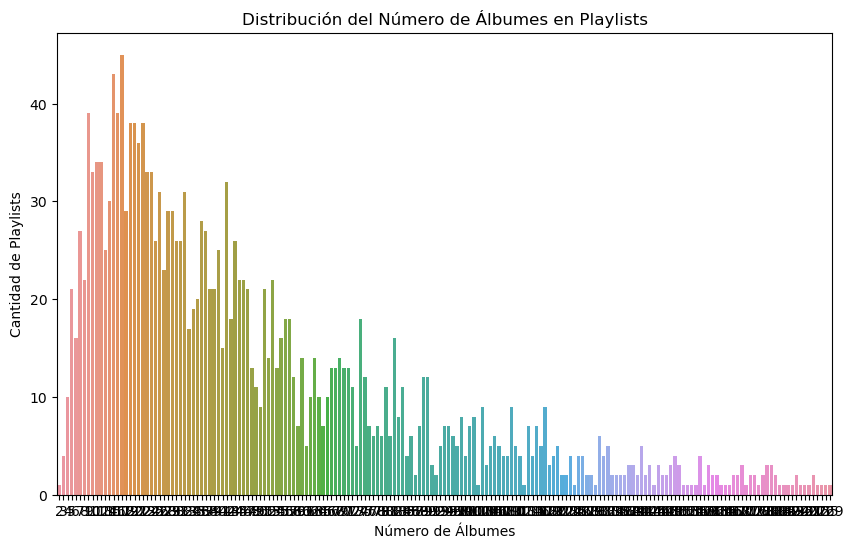

In [ ]:
# Gráfico de barras para el número de álbumes en las playlists
plt.figure(figsize=(10, 6))
sns.countplot(x='num_albums', data=df)
plt.title('Distribución del Número de Álbumes en Playlists')
plt.xlabel('Número de Álbumes')
plt.ylabel('Cantidad de Playlists')
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


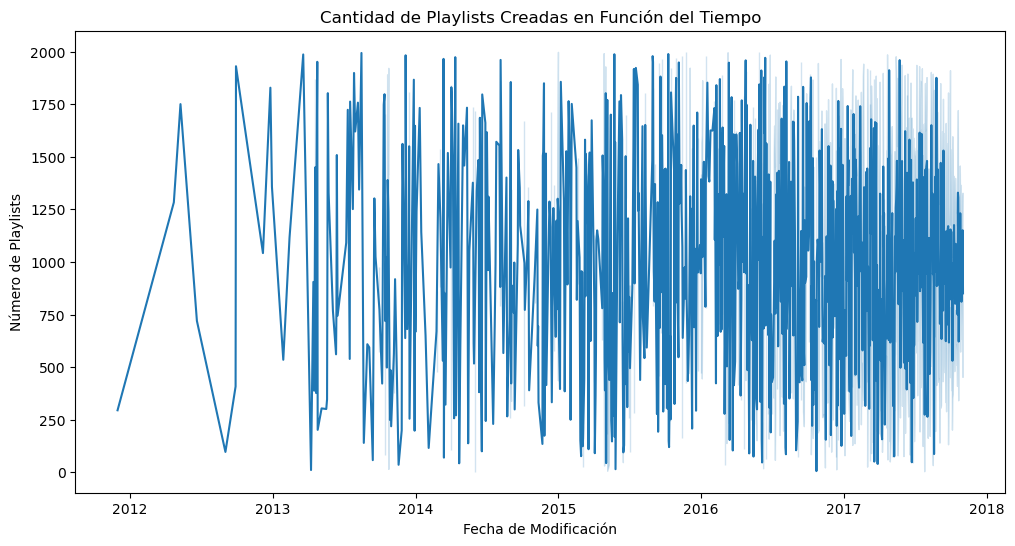

In [ ]:
# Gráfico de líneas para la cantidad de playlists creadas en función del tiempo
df['modified_at'] = pd.to_datetime(df['modified_at'], unit='s')
plt.figure(figsize=(12, 6))
sns.lineplot(x='modified_at', y='pid', data=df)
plt.title('Cantidad de Playlists Creadas en Función del Tiempo')
plt.xlabel('Fecha de Modificación')
plt.ylabel('Número de Playlists')
plt.show()

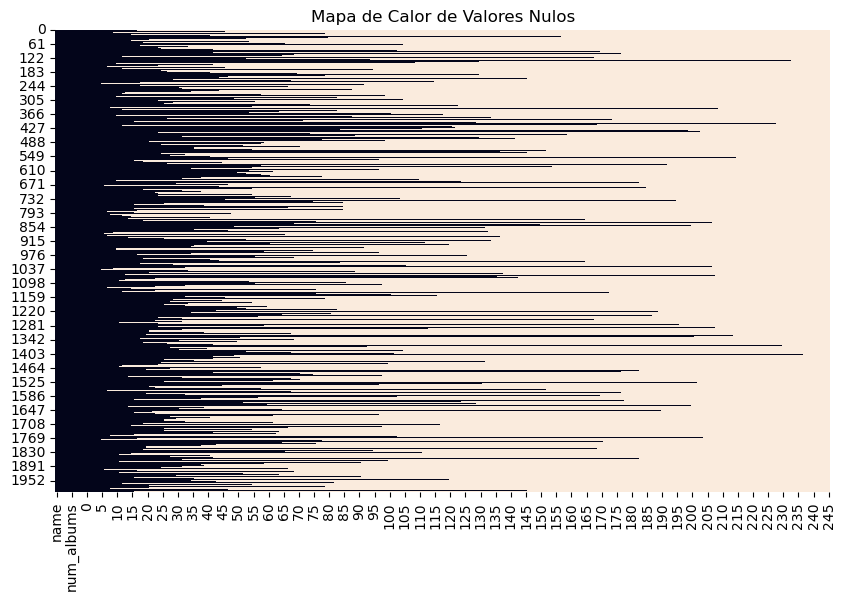

In [ ]:
# Mapa de calor para valores nulos
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Mapa de Calor de Valores Nulos')
plt.show()

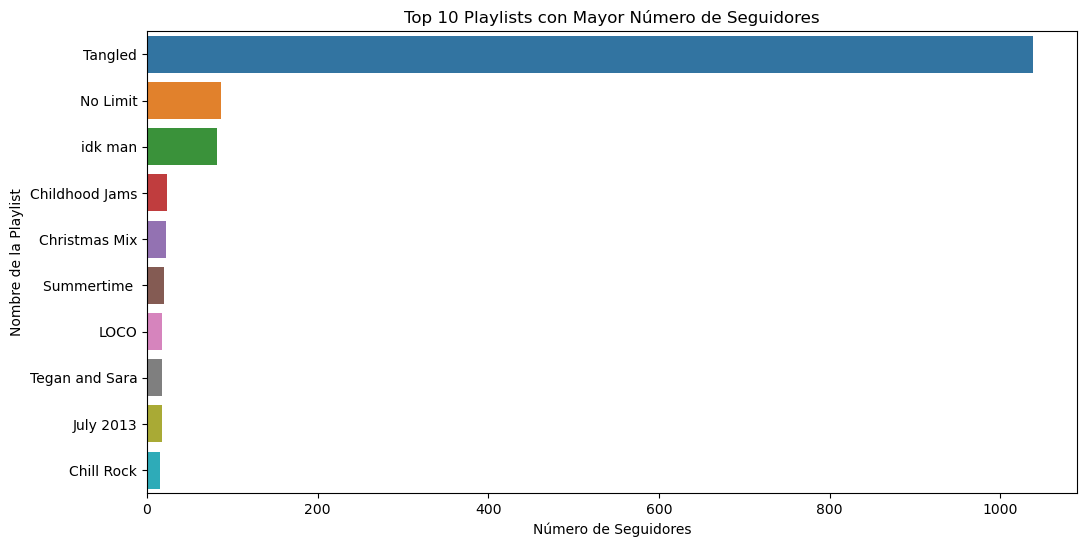

In [ ]:

# Gráfico de barras para playlists con el mayor número de seguidores
plt.figure(figsize=(12, 6))
sns.barplot(x='num_followers', y='name', data=df.sort_values('num_followers', ascending=False).head(10))
plt.title('Top 10 Playlists con Mayor Número de Seguidores')
plt.xlabel('Número de Seguidores')
plt.ylabel('Nombre de la Playlist')
plt.show()

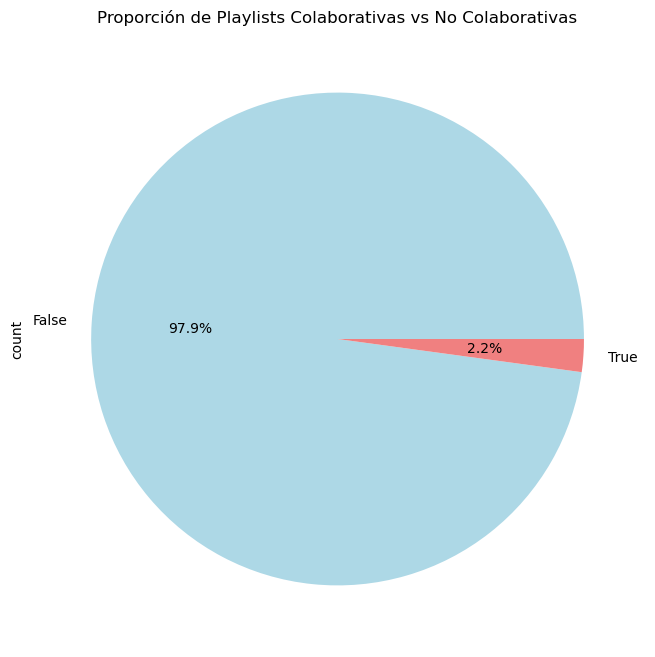

In [ ]:
# Gráfico de pie para la proporción de playlists colaborativas vs no colaborativas
plt.figure(figsize=(8, 8))
df['collaborative'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proporción de Playlists Colaborativas vs No Colaborativas')
plt.show()

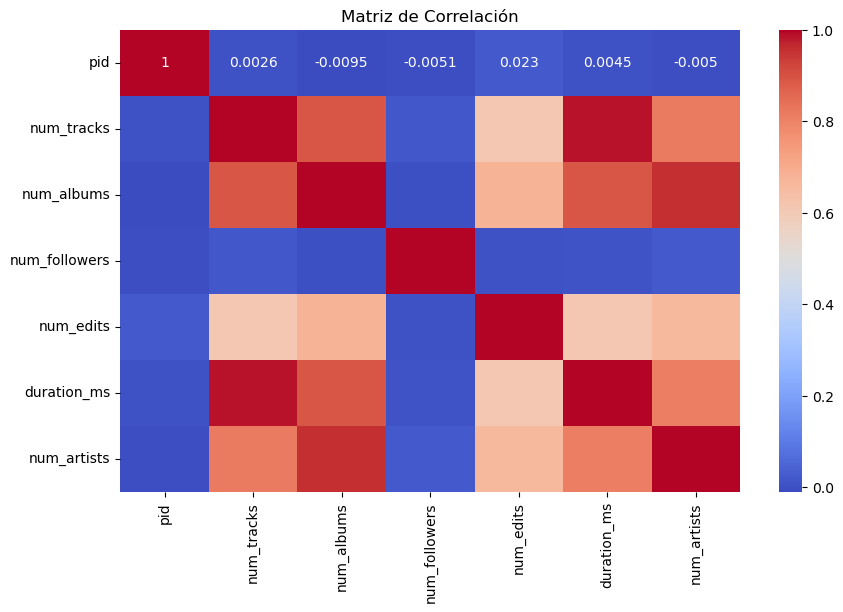

In [ ]:
# Seleccionar solo columnas numéricas
numeric_columns = df.select_dtypes(include=['number'])

# Matriz de correlación
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Get song features from playlists extracted

In [ ]:
# Spotify credentials
os.environ["SPOTIPY_CLIENT_ID"] = '908aecbf256e42b1b8d06587088fcde9'
os.environ["SPOTIPY_CLIENT_SECRET"] = 'e028bd264961437f9ad102005ecc6d6c'
os.environ['SPOTIPY_REDIRECT_URI'] = 'https://github.com/cccaballero1/RecSys/tree/main'
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [ ]:
import pandas as pd

# Code to retrieve and add data to an existing df
df_list = []
feats_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\Data\2024_03_29_14_33_38_playlists_1000.csv')

# Remove 'spotify:artist:' from artist_uri
feats_df['artist_uri'] = feats_df['artist_uri'].str.replace('spotify:artist:', '')

# Remove 'spotify:album:' from album_uri
feats_df['album_uri'] = feats_df['album_uri'].str.replace('spotify:album:', '')

# Remove 'spotify:track:' from track_uri
feats_df['track_uri'] = feats_df['track_uri'].str.replace('spotify:track:', '')

idx = len(feats_df)
df_list.append(feats_df)
feats_df


,pos,artist_name,playlist_index,artist_uri,album_uri,duration_ms,album_name,track_uri,track_name
0,0,Missy Elliott,1,2wIVse2owClT7go1WT98tk,6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop)
1,1,Britney Spears,1,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,6I9VzXrHxO9rA9A5euc8Ak,Toxic
2,2,Beyoncé,1,6vWDO969PvNqNYHIOW5v0m,25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love
3,3,Justin Timberlake,1,31TPClRtHm23RisEBtV3X7,6QPkyl04rXwTGlGlcYaRoW,267266,Justified,1AWQoqb9bSvzTjaLralEkT,Rock Your Body
4,4,Shaggy,1,5EvFsr3kj42KNv97ZEnqij,6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me
...,...,...,...,...,...,...,...,...,...
995,38,Clean Bandit,1,6MDME20pz9RveH9rEXvrOM,2xVeccmEU0zklK4XSKiDCW,227833,I Cry When I Laugh,5HuqzFfq2ulY1iBAW5CxLe,Rather Be (feat. Jess Glynne)
996,39,Jason Gray,1,4i2mkyKkRrc0OvPrWqb4BE,3E7uWZAn35nbYiwAHuya2l,227266,A Way To See In The Dark,5eqz8gTDU13s7x2DZKiQA9,Remind Me Who I Am
997,40,Mary Lambert,1,5Z2NUZiY3FA00HKu5WTMhA,7mmdJJoGtwStzZImLRmRFS,223405,Heart On My Sleeve,3V3iy4K6paycRmTyrjQVwi,Secrets
998,41,Sheppard,1,6VxCmtR7S3yz4vnzsJqhSV,0ecUmBX4469DFW5iWkuHia,218227,Bombs Away,0qt5f5EL92o8Snzopsv0en,Geronimo


In [ ]:
import pandas as pd

# Code to retrieve and add data to an existing df
df_list = []
feats_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\Data\2024_03_29_14_33_38_playlists_1000.csv')

# Remove 'spotify:track:' from track_uri
#feats_df['track_uri'] = feats_df['track_uri'].str.replace('spotify:track:', '')

# Add ' ' at the beginning and end of each track_uri
feats_df['track_uri'] = "'" + feats_df['track_uri'] + "'"

# Split track_uri into chunks of 100 and create a new row for each chunk
chunks = [feats_df[i:i+100] for i in range(0, len(feats_df), 100)]

# Create a list to store the merged track URIs
merged_track_uris_list = []

# Iterate over chunks and merge track URIs, then append to the list
for chunk in chunks:
    merged_track_uris = ','.join(chunk['track_uri'])
    merged_track_uris_list.append(merged_track_uris)

# Create a new DataFrame with the merged track URIs
track_uri_df = pd.DataFrame({'merged_track_uris': merged_track_uris_list})

# Output the new DataFrame
print(track_uri_df)

 # Save the audio_features as a CSV file
track_uri_df.to_csv(f'track_uri.csv', index=False)

                                   merged_track_uris
0  'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI','spotif...
1  'spotify:track:7tIJDktakabGoHjwTTa35W','spotif...
2  'spotify:track:0tOyrixMQ17NUznPIxYtVD','spotif...
3  'spotify:track:1V4jC0vJ5525lEF1bFgPX2','spotif...
4  'spotify:track:7urOj7zwJa2rG5eWc7Nz4W','spotif...
5  'spotify:track:391R7sGZ4SX7qPdpAsfiGW','spotif...
6  'spotify:track:682cnKvTcXg59UvQUic4t2','spotif...
7  'spotify:track:2TbQOKDTGrg3ppGkO3gltX','spotif...
8  'spotify:track:5vYA1mW9g2Coh1HUFUSmlb','spotif...
9  'spotify:track:1UvHbGEsb66bPueCDFUgJS','spotif...


In [ ]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Initialize Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id='6114d0a592c44db3b093987159165913', client_secret='bee796687b4b441490678b2851f8ca0c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Retrieve audio features for the track_uri
audio_features = sp.audio_features(['spotify:track:1UvHbGEsb66bPueCDFUgJS','spotify:track:2rj6Vf9LTjEec7B1ZKmUcg','spotify:track:2ZBYcZBEjn3Mih9ItJx6jT','spotify:track:1c4OpZ2G1MEcEKSknUZjdD','spotify:track:4xyNG8vZR3g8FnphVkbjRo','spotify:track:3Q3LbqfjDhWjmyYeirHfDe','spotify:track:6qnaCx4wQQBqFd9XdQyWjC','spotify:track:4SyowQi18ym4zJGJDBnsTj','spotify:track:1jPZgfC9tWFNf7iBGdrTPV','spotify:track:4m94RGz3F0bq7FvZlKvn5X','spotify:track:3b51fabMtwwqPN60d8karQ','spotify:track:3fttmSWGThBQTNkuHMoCTN','spotify:track:0JdKraw5FJpJv0MxK61QET','spotify:track:3Cl35xMXJUEhpPaYBeNUQR','spotify:track:2ZWlPOoWh0626oTaHrnl2a','spotify:track:314J5QSFfddZFfUpFGjfeQ','spotify:track:3tchJ8gDgMdaSxpaLxlr1F','spotify:track:2AA2ztVvJ4G8QOMY8S6uuG','spotify:track:5ZyVc23cCY8F7Vw4AEk20P','spotify:track:1aJyuLBSzjnv8nByAybneD','spotify:track:54rL22ium6VKqXYYmiqGcw','spotify:track:0Xl6wED9M0japQC5Gh2hmb','spotify:track:1041AugHRUItomim5CP2kv','spotify:track:35IOqeFafpJocc99jrVDZA','spotify:track:0esC11I90ngZYSb0b29aOT','spotify:track:09eSdS5RTgyodJt3krr5AC','spotify:track:7BT9NNN1mNFU3l3u8hX6MW','spotify:track:4Uom1ELJU8GRoGXhS69f4u','spotify:track:6eTttAOfuEWfGOv6bbfaWw','spotify:track:1b8Zlu3aMVxEbyeospYPrK','spotify:track:23BsnzyFKMoAE9cYULyVyi','spotify:track:70x1x9NbSJJXkrgvIyyAVX','spotify:track:3el4x04xzgIYgezUAflR6t','spotify:track:1CLmFKW99S8eJrebO3GB04','spotify:track:2JCxAPqEHEEneITkhsyBam','spotify:track:49KVrwFWzaOnbdvwiY6nOW','spotify:track:0jeJR3LdrC2QJNviq7wjzp','spotify:track:0ImjeKKMwhUNJwVe4JXEDy','spotify:track:2YFOBRfkZoEw5zEuSFCMb9','spotify:track:6vPaHzQsIjEkWE5gFkmEQX','spotify:track:1US5sDsfGVTASyDgb4BI30','spotify:track:6XW2rKHwNnX5qzk79Qis9w','spotify:track:48sJGpBLqQTs0sZ2ImHJof','spotify:track:4mUt2M3Y4YiQrNJZY9TrOX','spotify:track:1gofFAslBqWqeZ1F73GaJe','spotify:track:4nUT86Gudk78XZLjcScZ3M','spotify:track:01ZpFhrMMqKPVCwyqXneVp','spotify:track:5a4d1YVJ3OBFRqgAhRK36o','spotify:track:41bqk7dKc9Qj1WBQ0Jtbfx','spotify:track:2os0aK782bakCPmjow0SU0','spotify:track:0y6Mp5Y1OxHtzxi6AwewPt','spotify:track:5wMt5iY1NV2htOp3Cbam1X','spotify:track:0V1xJXwwuXsr5oW5nSBVOC','spotify:track:4CzUdbxR8UJAXqG6JYM3ma','spotify:track:70cpuGFNENOHuqNhtLVFJY','spotify:track:6FxbwB6o1MKOy0dHvxNr2W','spotify:track:5Ohxk2dO5COHF1krpoPigN','spotify:track:0j6YwWZVHsIFKr5FDEu68o','spotify:track:7nqhFb3g7ZtzOEV2QwvyBI','spotify:track:3Jc0ABqhf9yMLn8bbAdmKX','spotify:track:3uhBIQ7tv8j1FME8cFGEfG','spotify:track:5b88tNINg4Q4nrRbrCXUmg','spotify:track:4rHZZAmHpZrA3iH5zx8frV','spotify:track:5g7sDjBhZ4I3gcFIpkrLuI','spotify:track:32OlwWuMpZ6b0aN2RZOeMS','spotify:track:4kbj5MwxO1bq9wjT5g9HaA','spotify:track:0bjBsRPf86v7qyuQbq5SCG','spotify:track:58jx3tTuDuzHysC77c0AQd','spotify:track:3utsJdhRUrJA8avrOawi8D','spotify:track:39IX2P1yPA5opcTaHXLPlW','spotify:track:6gj08XDlv9Duc2fPOxUmVD','spotify:track:1fidCEsYlaVE3pHwKCvpFZ','spotify:track:5jE48hhRu8E6zBDPRSkEq7','spotify:track:468jbp2UybC99Ic7MrTDji','spotify:track:4VrWlk8IQxevMvERoX08iC','spotify:track:6qn9YLKt13AGvpq9jfO8py','spotify:track:6g1NlCpW7fgqDnWbCCDrHl','spotify:track:1SD2UjPRag3gdqsB3adJA2','spotify:track:7GJClzimvMSghjcrKxuf1M','spotify:track:15DrrIod12Tc2IoMaHiwlQ','spotify:track:6nYD1UPZzBfnA9aL5TrWTc','spotify:track:4eLSCSELtKxZwXnFbNLXT5','spotify:track:1DirzC3jiBhwQ15rajeobq','spotify:track:6YUFByainM0IB52DNObY5t','spotify:track:5edBgVtRD0fvWk140Sl21T','spotify:track:4MflGTO2ZTcSQ12bWcyRgI','spotify:track:1CkvWZme3pRgbzaxZnTl5X','spotify:track:76N7FdzCI9OsiUnzJVLY2m','spotify:track:3gbBpTdY8lnQwqxNCcf795','spotify:track:5j9iuo3tMmQIfnEEQOOjxh','spotify:track:3yZQk5PC52CCmT4ZaTIKvv','spotify:track:53Pgsvu3qSYO2aXt5J2vcL','spotify:track:6u0oHknFYrnUd42A6rvFly','spotify:track:1BwhFXqoIsePt21WyWIttb','spotify:track:5L95vS64rG1YMIFm1hLjyZ','spotify:track:5HuqzFfq2ulY1iBAW5CxLe','spotify:track:5eqz8gTDU13s7x2DZKiQA9','spotify:track:3V3iy4K6paycRmTyrjQVwi','spotify:track:0qt5f5EL92o8Snzopsv0en','spotify:track:3nSiB5WCF2pmRQrYSsteHv'])

# Convert the audio_features to a DataFrame
audio_features_df = pd.DataFrame(audio_features)

# Save the audio_features as a CSV file
audio_features_df.to_csv(f'track_audio_features_10.csv')


In [ ]:
#artistas_unicos = feats_df['artist_name'].unique()
#artistas_unicos

artistas_unicos = feats_df['artist_name'].unique()
max_artistas_por_fila = 100

# Dividir el array en filas de máximo 100 artistas
filas_artistas = [artistas_unicos[i:i+max_artistas_por_fila] for i in range(0, len(artistas_unicos), max_artistas_por_fila)]

# Imprimir las filas con valores separados por coma y conservando comillas simples y llaves
for i, fila in enumerate(filas_artistas):
    fila_coma = ', '.join([f"'{valor}'" for valor in fila])
    print(f"Fila {i+1}: [{fila_coma}]")



Fila 1: ['Missy Elliott', 'Britney Spears', 'Beyoncé', 'Justin Timberlake', 'Shaggy', 'Usher', 'The Pussycat Dolls', 'Destiny's Child', 'OutKast', 'Nelly Furtado', 'Jesse McCartney', 'Cassie', 'Omarion', 'Avril Lavigne', 'Chris Brown', 'Sheryl Crow', 'The Black Eyed Peas', 'Bowling For Soup', 'The Click Five', 'Jonas Brothers', 'Lil Mama', 'Cascada', 'Jason Derulo', 'Ne-Yo', 'Miley Cyrus', 'Boys Like Girls', 'Iyaz', 'Kesha', 'Justin Bieber', 'M.I.A.', 'The Killers', 'blink-182', 'The All-American Rejects', 'Vanessa Carlton', 'Cris Cab', 'Demi Lovato', 'We The Kings', 'Survivor', 'Daniel Tidwell', 'Kaleptik', 'Ben Foster', 'Leslie Odom Jr.', 'Christopher Jackson', 'Lin-Manuel Miranda', 'Led Zeppelin', 'Collective Soul', 'Nightwish', 'Seal', 'The Rolling Stones', 'Lynyrd Skynyrd', 'Boston', 'Toto', 'Kansas', 'Queen', 'Guns N' Roses', 'Creedence Clearwater Revival', 'Scorpions', 'Rush', 'Hoody', 'Loco', 'Park Kyung', 'BTS', 'Lovelyz', 'LEE HI', 'Ailee', 'Miso', 'Zion.T', 'KARD', 'Soyou & 

In [ ]:
import pandas as pd

# Función para obtener el género de un artista
def obtener_genero_artista(nombres_artistas):
    generos = []
    for nombre in nombres_artistas:
        result = sp.search(nombre, type='artist')
        if len(result['artists']['items']) > 0:
            artist = result['artists']['items'][0]
            if 'genres' in artist:
                generos.append(artist['genres'])
            else:
                generos.append(None)
        else:
            generos.append(None)
    return generos

# Nombre del artista
nombre_artista =  ['Pharrell Williams', 'Mark Ronson', 'WALK THE MOON', 'Matisyahu', 'Jess Glynne', 'You Me At Six', 'Meghan Trainor', 'Nico & Vinz', 'Avicii', 'Itch', 'George Ezra', 'Imagine Dragons', 'OneRepublic', 'Andy Grammer', 'Adele', 'Bastille', 'Panic! At The Disco', 'Bleachers', 'Jason Gray', 'Mary Lambert', 'Sheppard', 'Fall Out Boy']
# Obtener el género del artista
genero_artistas = obtener_genero_artista(nombre_artista)

# Crear un DataFrame
data = {'Nombre del Artista': nombre_artista, 'Géneros': genero_artistas}
df = pd.DataFrame(data)

# Guardar como CSV
df.to_csv('artistas_generos_7.csv', index=False)



# Unificar Chunks

In [ ]:
import os
import pandas as pd

# Directorio donde se encuentran los archivos
folder_path = r'C:\Users\admin\Downloads\Spotify Challenge'

# Lista para almacenar todos los DataFrames
dfs = []

# Iterar sobre todos los archivos en el directorio
for filename in os.listdir(folder_path):
    if filename.startswith("artistas_generos_") and filename.endswith(".csv"):
        # Obtener el número del chunk del archivo
        chunk_number = filename.split("_")[-1].split(".")[0]

        # Leer cada archivo CSV y agregarlo al DataFrame
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Agregar una columna para identificar el chunk
        df['chunk'] = int(chunk_number)

        dfs.append(df)

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dfs, ignore_index=True)

# Guardar el DataFrame combinado en un nuevo archivo CSV
combined_df.to_csv(os.path.join(folder_path, 'combined_artistas_generos.csv'), index=False)

print("Se ha creado el archivo CSV combinado con éxito.")


Se ha creado el archivo CSV combinado con éxito.


In [ ]:
import os
import pandas as pd

# Directorio donde se encuentran los archivos
folder_path = r'C:\Users\admin\Downloads\Spotify Challenge'

# Lista para almacenar todos los DataFrames
dfs = []

# Iterar sobre todos los archivos en el directorio
for filename in os.listdir(folder_path):
    if filename.startswith("track_audio_features_") and filename.endswith(".csv"):
        # Obtener el número del chunk del archivo
        chunk_number = filename.split("_")[-1].split(".")[0]

        # Leer cada archivo CSV y agregarlo al DataFrame
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Agregar una columna para identificar el chunk
        df['chunk'] = int(chunk_number)

        dfs.append(df)

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dfs, ignore_index=True)

# Guardar el DataFrame combinado en un nuevo archivo CSV
combined_df.to_csv(os.path.join(folder_path, 'combined_track_audio_features.csv'), index=False)

print("Se ha creado el archivo CSV combinado con éxito.")


Se ha creado el archivo CSV combinado con éxito.


In [ ]:
file_1 = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_track_audio_features.csv')
file_1

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,chunk
0,0,0.904,0.813,4,-7.105,0,0.1210,0.031100,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4,1
1,1,0.774,0.838,5,-3.914,0,0.1140,0.024900,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4,1
2,2,0.664,0.758,2,-6.583,0,0.2100,0.002380,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4,1
3,3,0.892,0.714,4,-6.055,0,0.1410,0.201000,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4,1
4,4,0.853,0.606,0,-4.596,1,0.0713,0.056100,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,95,0.699,0.579,10,-7.633,0,0.0536,0.280000,0.000222,0.2850,0.339,137.059,audio_features,6N9PAf91qP6aJIzT8bVoof,spotify:track:6N9PAf91qP6aJIzT8bVoof,https://api.spotify.com/v1/tracks/6N9PAf91qP6a...,https://api.spotify.com/v1/audio-analysis/6N9P...,291947,4,9
996,96,0.244,0.974,11,-2.491,0,0.0504,0.000417,0.553000,0.3680,0.664,141.891,audio_features,2xlgLLcGDnvaQXyyjGhRdG,spotify:track:2xlgLLcGDnvaQXyyjGhRdG,https://api.spotify.com/v1/tracks/2xlgLLcGDnva...,https://api.spotify.com/v1/audio-analysis/2xlg...,183147,4,9
997,97,0.596,0.894,0,-5.407,1,0.0265,0.008780,0.006590,0.1040,0.572,132.994,audio_features,36PQh1G6h7n9VWB799fXpI,spotify:track:36PQh1G6h7n9VWB799fXpI,https://api.spotify.com/v1/tracks/36PQh1G6h7n9...,https://api.spotify.com/v1/audio-analysis/36PQ...,260387,5,9
998,98,0.829,0.435,0,-10.136,1,0.0515,0.036300,0.878000,0.1190,0.594,103.816,audio_features,5VarZFY00sO54HErJ3TPCI,spotify:track:5VarZFY00sO54HErJ3TPCI,https://api.spotify.com/v1/tracks/5VarZFY00sO5...,https://api.spotify.com/v1/audio-analysis/5Var...,230147,4,9


In [ ]:
file_2 = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_artistas_generos.csv')
file_2

,Nombre del Artista,Géneros,chunk
0,Missy Elliott,"['dance pop', 'hip hop', 'hip pop', 'neo soul'...",1
1,Britney Spears,"['dance pop', 'pop']",1
2,Beyoncé,"['pop', 'r&b']",1
3,Justin Timberlake,"['dance pop', 'pop']",1
4,Shaggy,"['dance pop', 'pop rap', 'reggae fusion']",1
...,...,...,...
616,Bleachers,"['indie pop', 'indie poptimism', 'modern rock'...",7
617,Jason Gray,"['ccm', 'christian alternative rock', 'christi...",7
618,Mary Lambert,['neo mellow'],7
619,Sheppard,"['australian indie', 'australian pop', 'folk-p...",7


In [ ]:
import pandas as pd

# Leer los archivos CSV
playlist_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\Data\2024_03_29_14_33_38_playlists_1000.csv')
track_audio_features_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_track_audio_features.csv')
artistas_generos_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_artistas_generos.csv', sep=';')

# Combinar playlist_df y track_audio_features_df por la columna 'track_uri'
merged_df = pd.merge(playlist_df, track_audio_features_df, on='track_uri', how='left')

# Combinar con artistas_generos_df por la columna 'artist_name'
merged_df = pd.merge(merged_df, artistas_generos_df, on='artist_name', how='left')

# Guardar el DataFrame combinado en un nuevo archivo CSV
merged_df.to_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_data.csv', index=False)

print("Se ha creado el archivo CSV combinado con éxito.")


Se ha creado el archivo CSV combinado con éxito.


In [ ]:

# Leer el archivo CSV
data_df = pd.read_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_data.csv')

# Convertir loudness de dB a mW
data_df['loudness_mW'] = 10 ** (data_df['loudness'] / 10)

# Guardar el DataFrame modificado en un nuevo archivo CSV
data_df.to_csv(r'C:\Users\admin\Downloads\Spotify Challenge\combined_data_converted.csv', index=False)

print("Se ha creado el archivo CSV con la característica de loudness convertida a mW.")


Se ha creado el archivo CSV con la característica de loudness convertida a mW.


## DESDE ACÁ VA LO DE LA PLAYLIST

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Initialize Spotipy client
client_credentials_manager = SpotifyClientCredentials(client_id='6114d0a592c44db3b093987159165913', client_secret='bee796687b4b441490678b2851f8ca0c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlist_uri = 'spotify:playlist:447Mg9UnLbA3OPYuaTWbN7'

# Get playlist items
playlist_details = sp.playlist_items(playlist_uri, limit=100)

# Extract relevant information
tracks = playlist_details['items']
track_data = []

for index, track in enumerate(tracks):
    track_info = track['track']
    track_data.append({
        'playlist_index': index + 1,
        'artist_name': ', '.join([artist['name'] for artist in track_info['artists']]),
        'artist_uri': ', '.join([artist['uri'] for artist in track_info['artists']]),
        'album_name': track_info['album']['name'],
        'album_uri': track_info['album']['uri'],
        'track_name': track_info['name'],
        'track_uri': track_info['uri'],
        'duration_ms_x': track_info['duration_ms'],
        'release_date': track_info['album']['release_date'],
        'popularity': track_info['popularity']
    })

# Create DataFrame
fav_songs_feats_df = pd.DataFrame(track_data)

fav_songs_feats_df

,playlist_index,artist_name,artist_uri,album_name,album_uri,track_name,track_uri,duration_ms_x,release_date,popularity
0,1,OneRepublic,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,Dreaming Out Loud (International Version),spotify:album:72c3ugX0yPaFCtEuHPDXaY,Apologize,spotify:track:6fOPuabPdAJ0HgqJFcDGb1,208106,2007-01-01,0
1,2,OneRepublic,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,Waking Up,spotify:album:4ySSx2L6h2siW22LK6dwhN,Secrets,spotify:track:4zweVv3Wa6XgexhoUOzkYs,224693,2009-01-01,0
2,3,OneRepublic,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,Native,spotify:album:42UJjk8i8L0De7lQtu7sqi,Counting Stars,spotify:track:1QzFhzIOW7CyRJLpmq5CM0,257386,2014-01-01,58
3,4,Christina Perri,spotify:artist:7H55rcKCfwqkyDFH9wpKM6,A Thousand Years,spotify:album:15yvc643iYfQtb6zh9NEJo,a thousand years,spotify:track:6lanRgr6wXibZr8KgzXxBl,285120,2011-10-18,82
4,5,Aqualung,spotify:artist:3uT7nEkZwWc2GBiqUZGoOe,Strange & Beautiful,spotify:album:2w1zxP11Ec4G3fF92ErPyp,Brighter Than Sunshine,spotify:track:3W6UA36h0zahjxU709wLSI,241360,2005-01-17,41
...,...,...,...,...,...,...,...,...,...,...
95,96,The Verve,spotify:artist:2cGwlqi3k18jFpUyTrsR84,Urban Hymns (Remastered 2016),spotify:album:52AeC4gwbxDfFlLHgK1ByD,Bitter Sweet Symphony - Remastered 2016,spotify:track:57iDDD9N9tTWe75x6qhStw,357266,1997-09-29,79
96,97,Thirty Seconds To Mars,spotify:artist:0RqtSIYZmd4fiBKVFqyIqD,This Is War (Deluxe),spotify:album:5nI4Eo1vWUWXzeT4WrzTGL,Hurricane,spotify:track:69wXbIKtG6hzE4ID0wJTry,372133,2009,43
97,98,Olly Alexander (Years & Years),spotify:artist:5vBSrE1xujD2FXYRarbAXc,Communion (Deluxe),spotify:album:0bWYlK9rRmIB68icHx9PNR,Desire,spotify:track:20ouJW3BTG6aFAugslihCw,206773,2015-07-10,58
98,99,"ZAYN, Sia","spotify:artist:5ZsFI1h6hIdQRw2ti0hz81, spotify...",Icarus Falls,spotify:album:1DF9B2hfwX4EdgEFwGcRwh,Dusk Till Dawn (feat. Sia) - Radio Edit,spotify:track:3e7sxremeOE3wTySiOhGiP,239000,2018-12-14,80


In [ ]:
# Create a list of all track URIs
track_uris = fav_songs_feats_df['track_uri'].tolist()

# Display the list
print(track_uris)


['spotify:track:6fOPuabPdAJ0HgqJFcDGb1', 'spotify:track:4zweVv3Wa6XgexhoUOzkYs', 'spotify:track:1QzFhzIOW7CyRJLpmq5CM0', 'spotify:track:6lanRgr6wXibZr8KgzXxBl', 'spotify:track:3W6UA36h0zahjxU709wLSI', 'spotify:track:0ZSmRnXnP5fdANtVlCok1g', 'spotify:track:0JoaFxLgrqbWutREzcZBzS', 'spotify:track:3GeeyHU1Q6xjyeXjRAjBoo', 'spotify:track:2vPcuc4MgKP2PPdj4OQ0SV', 'spotify:track:1WP1r7fuvRqZRnUaTi2I1Q', 'spotify:track:7yHEDfrJNd0zWOfXwydNH0', 'spotify:track:2ih2U8ttFzCjnQ5njF3SrR', 'spotify:track:5VVwwfK6Cp9IydkhKfJUEq', 'spotify:track:6ZSO7kPn8IMJFymyticbJO', 'spotify:track:6vrUTGn5p8IrfTZ0J6sIVM', 'spotify:track:5qqabIl2vWzo9ApSC317sa', 'spotify:track:52Bg6oaos7twR7IUtEpqcE', 'spotify:track:1uoL9GX45dTnmrWQ7Ii1Ft', 'spotify:track:19KEKRHlCuBswgShavMey0', 'spotify:track:6b2oQwSGFkzsMtQruIWm2p', 'spotify:track:135cNW8kQtiTId7qcsJfVC', 'spotify:track:0gmbgwZ8iqyMPmXefof8Yf', 'spotify:track:0FE9t6xYkqWXU2ahLh6D8X', 'spotify:track:34gCuhDGsG4bRPIf9bb02f', 'spotify:track:5UwmnJv2F8SlDQTQnEsAsf',

In [ ]:
# Retrieve audio features for the track_uri
audio_features = sp.audio_features(track_uris)

# Create DataFrame
audio_features = pd.DataFrame(audio_features)

audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.593,0.740,8,-6.120,1,0.0339,0.36300,0.000022,0.1020,0.5020,118.008,audio_features,6fOPuabPdAJ0HgqJFcDGb1,spotify:track:6fOPuabPdAJ0HgqJFcDGb1,https://api.spotify.com/v1/tracks/6fOPuabPdAJ0...,https://api.spotify.com/v1/audio-analysis/6fOP...,208107,4
1,0.516,0.764,2,-6.223,1,0.0366,0.07170,0.000000,0.1150,0.3760,148.021,audio_features,4zweVv3Wa6XgexhoUOzkYs,spotify:track:4zweVv3Wa6XgexhoUOzkYs,https://api.spotify.com/v1/tracks/4zweVv3Wa6Xg...,https://api.spotify.com/v1/audio-analysis/4zwe...,224693,4
2,0.663,0.705,1,-4.972,0,0.0385,0.06540,0.000000,0.1170,0.4770,122.014,audio_features,1QzFhzIOW7CyRJLpmq5CM0,spotify:track:1QzFhzIOW7CyRJLpmq5CM0,https://api.spotify.com/v1/tracks/1QzFhzIOW7Cy...,https://api.spotify.com/v1/audio-analysis/1QzF...,257387,4
3,0.421,0.407,10,-7.445,1,0.0267,0.30900,0.000961,0.1100,0.1610,139.028,audio_features,6lanRgr6wXibZr8KgzXxBl,spotify:track:6lanRgr6wXibZr8KgzXxBl,https://api.spotify.com/v1/tracks/6lanRgr6wXib...,https://api.spotify.com/v1/audio-analysis/6lan...,285120,3
4,0.314,0.483,11,-8.365,1,0.0351,0.22900,0.026900,0.5640,0.3480,145.047,audio_features,3W6UA36h0zahjxU709wLSI,spotify:track:3W6UA36h0zahjxU709wLSI,https://api.spotify.com/v1/tracks/3W6UA36h0zah...,https://api.spotify.com/v1/audio-analysis/3W6U...,241360,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.356,0.917,9,-6.006,1,0.0479,0.03350,0.000000,0.4060,0.5180,171.176,audio_features,57iDDD9N9tTWe75x6qhStw,spotify:track:57iDDD9N9tTWe75x6qhStw,https://api.spotify.com/v1/tracks/57iDDD9N9tTW...,https://api.spotify.com/v1/audio-analysis/57iD...,357267,4
96,0.533,0.747,10,-5.678,0,0.0443,0.04100,0.000006,0.2610,0.2770,124.970,audio_features,69wXbIKtG6hzE4ID0wJTry,spotify:track:69wXbIKtG6hzE4ID0wJTry,https://api.spotify.com/v1/tracks/69wXbIKtG6hz...,https://api.spotify.com/v1/audio-analysis/69wX...,372133,4
97,0.685,0.792,10,-4.157,0,0.0443,0.22300,0.000000,0.3340,0.7360,126.002,audio_features,20ouJW3BTG6aFAugslihCw,spotify:track:20ouJW3BTG6aFAugslihCw,https://api.spotify.com/v1/tracks/20ouJW3BTG6a...,https://api.spotify.com/v1/audio-analysis/20ou...,206773,4
98,0.259,0.437,11,-6.589,0,0.0386,0.10200,0.000001,0.1060,0.0951,180.042,audio_features,3e7sxremeOE3wTySiOhGiP,spotify:track:3e7sxremeOE3wTySiOhGiP,https://api.spotify.com/v1/tracks/3e7sxremeOE3...,https://api.spotify.com/v1/audio-analysis/3e7s...,239000,4


In [ ]:
# Merge the two DataFrames
merged_df = pd.merge(fav_songs_feats_df, audio_features, left_on='track_uri', right_on='uri', how='inner')

# Drop the redundant 'uri' column
merged_df.drop(columns='uri', inplace=True)

# Save the merged DataFrame as a CSV file
merged_df.to_csv('fav_songs_feats_df.csv', index=False)

print("CSV file saved successfully.")


CSV file saved successfully.
